In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import os
from collections import namedtuple
%matplotlib inline

### 클래스(label) 확인

In [2]:
LABELS = []
for folder in glob.glob('./data/*') :
    label = folder.split('/')[-1]
    # label = label.split('\\')[-1]
    # print(label)
    LABELS.append(label)
print(LABELS)

['No_overrun', 'NO_U-turn', '100', 'NO_left', 'Height', 'NO_entry', 'No_twowheel', 'NO_parking_stop', 'Weight', 'No_walk', '50', '60', '40', 'Default', 'NO_truck', 'NO_right', 'Other_Circle', 'No_straight', '30']


In [3]:
# 클래스 개수
N_CLASSES = len(LABELS)
# print(N_CLASSES)
# input image size
RESIZED_IMAGE = (64, 64)

In [4]:
# 클래스별 이미지 개수(개수만)
img_cnt = []
for label in LABELS :
    # print('./data/{}/*.jpg'.format(label))
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    img_cnt.append(cnt)
print(img_cnt)

[138, 2122, 30, 4401, 1245, 217, 44, 4603, 3, 0, 20926, 1155, 22, 366, 1756, 2474, 1646, 65, 1720]


In [5]:
# 클래스별 이미지 개수
labels_cnt = {}
for label in LABELS :
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    labels_cnt[label] = cnt
print(labels_cnt)

{'No_overrun': 138, 'NO_U-turn': 2122, '100': 30, 'NO_left': 4401, 'Height': 1245, 'NO_entry': 217, 'No_twowheel': 44, 'NO_parking_stop': 4603, 'Weight': 3, 'No_walk': 0, '50': 20926, '60': 1155, '40': 22, 'Default': 366, 'NO_truck': 1756, 'NO_right': 2474, 'Other_Circle': 1646, 'No_straight': 65, '30': 1720}


In [6]:
LABEL_IDX = {}
for label, i in zip(LABELS, range(0, N_CLASSES)) :
    LABEL_IDX[label] = i
print(LABEL_IDX)

{'No_overrun': 0, 'NO_U-turn': 1, '100': 2, 'NO_left': 3, 'Height': 4, 'NO_entry': 5, 'No_twowheel': 6, 'NO_parking_stop': 7, 'Weight': 8, 'No_walk': 9, '50': 10, '60': 11, '40': 12, 'Default': 13, 'NO_truck': 14, 'NO_right': 15, 'Other_Circle': 16, 'No_straight': 17, '30': 18}


In [7]:
IDX_LABEL = {}
for i, label in zip(range(0, N_CLASSES), LABELS) :
    IDX_LABEL[i] = label
print(IDX_LABEL)

{0: 'No_overrun', 1: 'NO_U-turn', 2: '100', 3: 'NO_left', 4: 'Height', 5: 'NO_entry', 6: 'No_twowheel', 7: 'NO_parking_stop', 8: 'Weight', 9: 'No_walk', 10: '50', 11: '60', 12: '40', 13: 'Default', 14: 'NO_truck', 15: 'NO_right', 16: 'Other_Circle', 17: 'No_straight', 18: '30'}


### 데이터셋 만들기

In [8]:
Dataset = namedtuple('Dataset', ['X', 'y'])
print(Dataset)

<class '__main__.Dataset'>


In [9]:
# 텐서플로우에 맞는 이미지 텐서 포맷 : [?, ?, ?, ?]
# 차원 확장
def to_tf_format(imgs) :
    return np.stack([img[:, :, :] for img in imgs], axis = 0).astype(np.float32)

In [10]:
# 그 이미지를 미리 정의한 형상으로 크기 재조정
# 레이블 원-핫 인코딩

def read_dataset(root_path, labels_arr, resize_to) :
    images = []
    labels = []
    
    for label_name in labels_arr :
        # 'data/no_parking/'
        full_path = root_path + '/' + label_name + '/'
        
        for img in glob.glob(full_path + '*.jpg') :
            image = cv2.imread(img).astype(np.float32)

            # 회색조로 변환
            # image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)[:, :, 0]
            
            # 크기 조정
            if resize_to : 
                image = cv2.resize(image, resize_to)
                
            # 라벨
            # 원-핫 인코딩
            label = np.zeros((N_CLASSES, ), dtype = np.float32)
            label[LABEL_IDX[label_name]] = 1.0
            
            images.append(image.astype(np.float32))
            labels.append(label)
            
    return Dataset(X = to_tf_format(images).astype(np.float32), y = np.matrix(labels).astype(np.float32))

In [11]:
dataset = read_dataset('data', LABELS, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(42933, 64, 64, 3)
(42933, 19)


In [12]:
print(dataset.X.shape, dataset.X[0, :, :, :].shape)

(42933, 64, 64, 3) (64, 64, 3)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


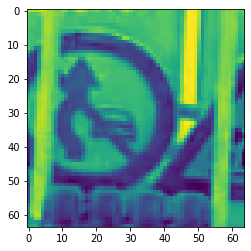

In [13]:
# 첫번째 표본
plt.imshow(dataset.X[0, :, :, 0].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[0, :])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


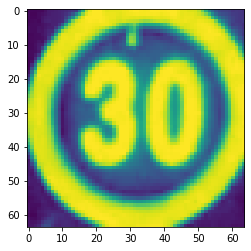

In [14]:
# 마지막 표본
plt.imshow(dataset.X[-1, :, :, 0].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[-1, :])

In [15]:
# train/test 데이터셋 분류
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size = 0.25, random_state = 101 )

In [16]:
# idx_train

In [17]:
# idx_test

In [18]:
len(idx_train), len(idx_test)

(32199, 10734)

In [19]:
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32199, 64, 64, 3)
(10734, 64, 64, 3)
(32199, 19)
(10734, 19)


In [20]:
# 훈련 데이터의 미니배치 생성

def minibatcher(X, y, batch_size, shuffle) :
    assert X.shape[0] == y.shape[0]
    n_samples = X.shape[0]
    
    if shuffle :
        idx = np.random.permutation(n_samples)
    else :
        idx = list(range(n_samples))
        
    for k in range(int(np.ceil(n_samples / batch_size))) :
        from_idx = k * batch_size
        to_idx = (k+1) * batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [21]:
for mb in minibatcher(X_train, y_train, 1000, True) :
    print(mb[0].shape, mb[1].shape)

(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(1000, 64, 64, 3) (1000, 19)
(199, 64, 64, 3) (199, 19)


### 모델 구성

In [22]:
# optimizer : AdamOptimizer

In [23]:
# hyperparameters
learning_rate = 0.001
training_epochs = 50
batch_size = 100

In [24]:
# 모델 생성 함수
def build_model(X) :
    
    # Layer1 / ImgIn shape = (?, 64, 64, 3)
    # kernel_size = [3, 3], filters = 32
    W1 = tf.Variable(tf.random_normal([3, 3, 3, 32], stddev = 0.01))
    L1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = 'SAME')
    #    Conv     -> (?, 64, 64, 32)
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    #    Pool     -> (?, 32, 32, 32)
    L1 = tf.nn.dropout(L1, keep_prob = keep_prob)
    
    # Layer2 / ImgIn shape = (?, 32, 32, 32)
    # kernel_size = [3, 3], filters = 64 
    W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev = 0.01))
    L2 = tf.nn.conv2d(L1, W2, strides = [1, 1, 1, 1], padding = 'SAME')
    #    Conv     -> (?, 32, 32, 64)
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    #    Pool     -> (?, 16, 16, 64)
    L2 = tf.nn.dropout(L2, keep_prob = keep_prob)
    
    # Layer3 / ImgIn shape = (?, 16, 16, 64)
    # kernel_size = [3, 3], filters = 128 
    W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev = 0.01))
    L3 = tf.nn.conv2d(L2, W3, strides = [1, 1, 1, 1], padding = 'SAME')
    #    Conv     -> (?, 16, 16, 128)
    L3 = tf.nn.relu(L3)
    L3 = tf.nn.max_pool(L3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    #    Pool     -> (?, 8, 8, 128)
    L3 = tf.nn.dropout(L3, keep_prob = keep_prob)
    L3_flat = tf.reshape(L3, [-1, 128 * 8 * 8])
    
    # Layer4 / FC 8x8x128 inputs -> 625 outputs
    W4 = tf.get_variable("W4", shape = [128 * 8 * 8, 625], initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.Variable(tf.random_normal([625]))
    L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
    L4 = tf.nn.dropout(L4, keep_prob = keep_prob)
    
    # Layer5 / Final FC 625 inputs -> (N_CLASSES) outputs
    W5 = tf.get_variable("W5", shape = [625, N_CLASSES], initializer=tf.contrib.layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([N_CLASSES]))
    logits = tf.matmul(L4, W5) + b5
    y_pred = tf.nn.softmax(logits)
    
    return y_pred, logits

In [25]:
# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input placeholders
X = tf.placeholder(tf.float32, [None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 3])
y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [26]:
y_pred, logits = build_model(X)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [27]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [28]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 모델 학습 및 저장

In [29]:
CHECK_POINT_DIR = './model.ckpt'
if not os.path.exists(CHECK_POINT_DIR) :
    os.makedirs(CHECK_POINT_DIR)

In [30]:
checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)
if checkpoint :
    print(checkpoint)
    print(checkpoint.model_checkpoint_path)

model_checkpoint_path: "./model.ckpt/model"
all_model_checkpoint_paths: "./model.ckpt/model"

./model.ckpt/model


In [31]:
# save model
saver = tf.train.Saver()

In [32]:
# initialize
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [33]:
# load a trained model
if checkpoint and checkpoint.model_checkpoint_path :
    try : 
        # saver = tf.train.import_meta_graph(checkpoint.model_checkpoint_path + '.meta')
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print('Successfully loaded : ', checkpoint.model_checkpoint_path)
    except :
        print("Error on loading old network weights")
else :
    print("Could not find old network weights")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt/model
Successfully loaded :  ./model.ckpt/model


In [43]:
# train
for epoch in range(training_epochs) :
    print("Epoch = ", epoch)
    costs = []

    for mb in minibatcher(X_train, y_train, batch_size, True) :
        feed_dict = {X : mb[0], y : mb[1], keep_prob : 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict = feed_dict)
        costs.append(c)
        
    print('cost = ', np.mean(costs))

Epoch =  0
cost =  0.045497783
Epoch =  1
cost =  0.05429868
Epoch =  2
cost =  0.046972662
Epoch =  3
cost =  0.042434108
Epoch =  4
cost =  0.034604408
Epoch =  5
cost =  0.039154217
Epoch =  6
cost =  0.034538593
Epoch =  7
cost =  0.046684634
Epoch =  8
cost =  0.036053825
Epoch =  9
cost =  0.03717682
Epoch =  10
cost =  0.03467186
Epoch =  11
cost =  0.052270103
Epoch =  12
cost =  0.03600009
Epoch =  13
cost =  0.045461576
Epoch =  14
cost =  0.047320846
Epoch =  15
cost =  0.0632792
Epoch =  16
cost =  0.0632095
Epoch =  17
cost =  0.021946423
Epoch =  18
cost =  0.034517247
Epoch =  19
cost =  0.038345918
Epoch =  20
cost =  0.04183213
Epoch =  21
cost =  0.048570048
Epoch =  22
cost =  0.05578598
Epoch =  23
cost =  0.049543496
Epoch =  24
cost =  0.06981262
Epoch =  25
cost =  0.06039566
Epoch =  26
cost =  0.06563429
Epoch =  27
cost =  0.040202543
Epoch =  28
cost =  0.050661087
Epoch =  29
cost =  0.037756275
Epoch =  30
cost =  0.055517495
Epoch =  31
cost =  0.035881616

In [44]:
saver.save(sess, CHECK_POINT_DIR + '/model')
print('Trained Model Saved.')

Trained Model Saved.


### 예측

In [36]:
# tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1)), tf.float32))

In [37]:
# print('accuracy : ', sess.run(accuracy, feed_dict = {X : X_test, y : y_test, keep_prob : 1}))

In [45]:
accuracies = []
for mb in minibatcher(X_test, y_test, batch_size, True) :
    feed_dict = {X : mb[0], y : mb[1], keep_prob : 1}
    acc = sess.run(accuracy, feed_dict = feed_dict)
    accuracies.append(acc)
print('accuracy = ', np.mean(accuracies))

accuracy =  0.9939814


In [39]:
# print(sess.run(y_pred, feed_dict = {X : X_test, keep_prob : 1}))

In [40]:
# pred_num = list(sess.run(tf.argmax(y_pred, axis = 1), feed_dict = {X : X_test, keep_prob : 1}))
# pred_name = []
# for num in pred_num :
#     pred_name.append(IDX_LABEL[num])

### 시각화

In [68]:
# classification_report
# 일부 데이터만
print(classification_report(sess.run(tf.argmax(y_test[:1000, :], 1)), 
                            sess.run(tf.argmax(y_pred, 1), feed_dict = {X : X_test[:1000, :, :, :], keep_prob : 1})))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00        46
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00       129
           4       1.00      0.94      0.97        33
           5       1.00      1.00      1.00         7
           7       0.99      0.99      0.99       108
           8       0.00      0.00      0.00         0
          10       0.99      1.00      0.99       488
          11       1.00      0.92      0.96        26
          13       0.88      1.00      0.93         7
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        54
          16       1.00      0.91      0.95        33
          17       1.00      1.00      1.00         1
          18       1.00      0.94      0.97        36

    accuracy                           0.99      1000
   macro avg       0.90   

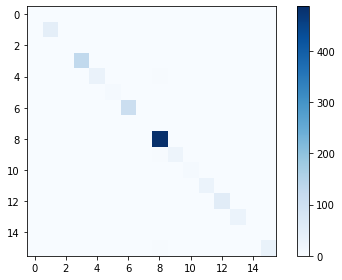

In [69]:
# confusion_matrix(혼동행렬)
cm = confusion_matrix(sess.run(tf.argmax(y_test[:1000, :], 1)), 
                            sess.run(tf.argmax(y_pred, 1), feed_dict = {X : X_test[:1000, :, :, :], keep_prob : 1}))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
plt.show()

In [34]:
# 세션 종료
sess.close()